In [30]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json

# plt.rcParams['figure.figsize'] = [15, 15]

In [31]:
camParamsPath = "Labels-GameState - Copy.json"
imgPath = 'Images/img1/'
maskPath = 'out2/tta/'
imgNum = 500

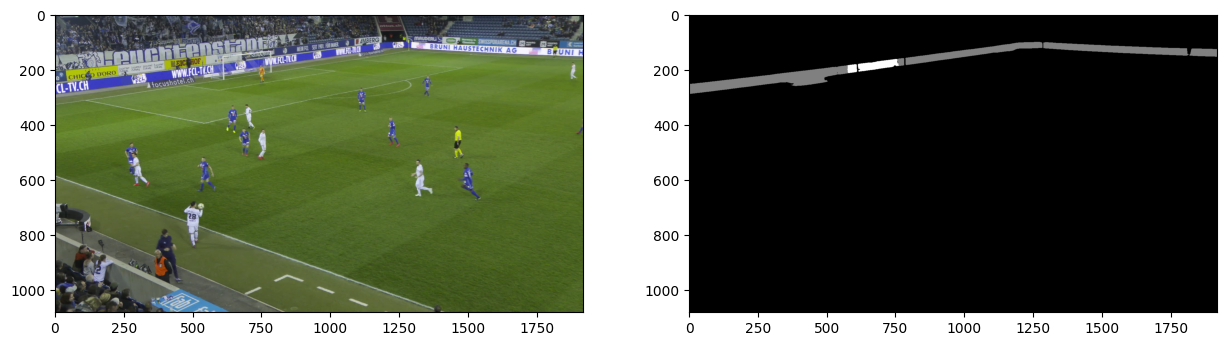

In [32]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()
cam.from_json_parameters(camParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

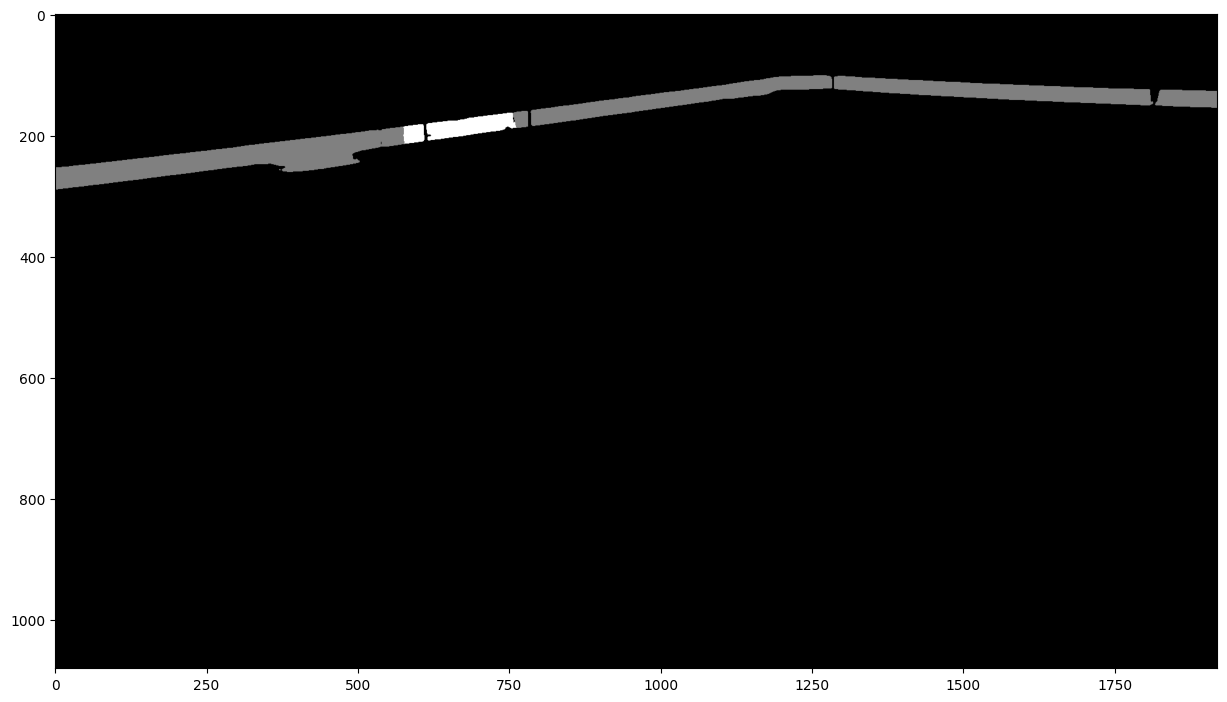

In [33]:
plt.imshow(mask, cmap='gray')
plt.savefig('mask.png', dpi=600)

In [34]:
billboardDepth = 4
points = np.float64([[-105/2 - billboardDepth, i, 0] for i in range(-34, 34+1, 2)])
points

array([[-56.5, -34. ,   0. ],
       [-56.5, -32. ,   0. ],
       [-56.5, -30. ,   0. ],
       [-56.5, -28. ,   0. ],
       [-56.5, -26. ,   0. ],
       [-56.5, -24. ,   0. ],
       [-56.5, -22. ,   0. ],
       [-56.5, -20. ,   0. ],
       [-56.5, -18. ,   0. ],
       [-56.5, -16. ,   0. ],
       [-56.5, -14. ,   0. ],
       [-56.5, -12. ,   0. ],
       [-56.5, -10. ,   0. ],
       [-56.5,  -8. ,   0. ],
       [-56.5,  -6. ,   0. ],
       [-56.5,  -4. ,   0. ],
       [-56.5,  -2. ,   0. ],
       [-56.5,   0. ,   0. ],
       [-56.5,   2. ,   0. ],
       [-56.5,   4. ,   0. ],
       [-56.5,   6. ,   0. ],
       [-56.5,   8. ,   0. ],
       [-56.5,  10. ,   0. ],
       [-56.5,  12. ,   0. ],
       [-56.5,  14. ,   0. ],
       [-56.5,  16. ,   0. ],
       [-56.5,  18. ,   0. ],
       [-56.5,  20. ,   0. ],
       [-56.5,  22. ,   0. ],
       [-56.5,  24. ,   0. ],
       [-56.5,  26. ,   0. ],
       [-56.5,  28. ,   0. ],
       [-56.5,  30. ,   0. ],
       [-5

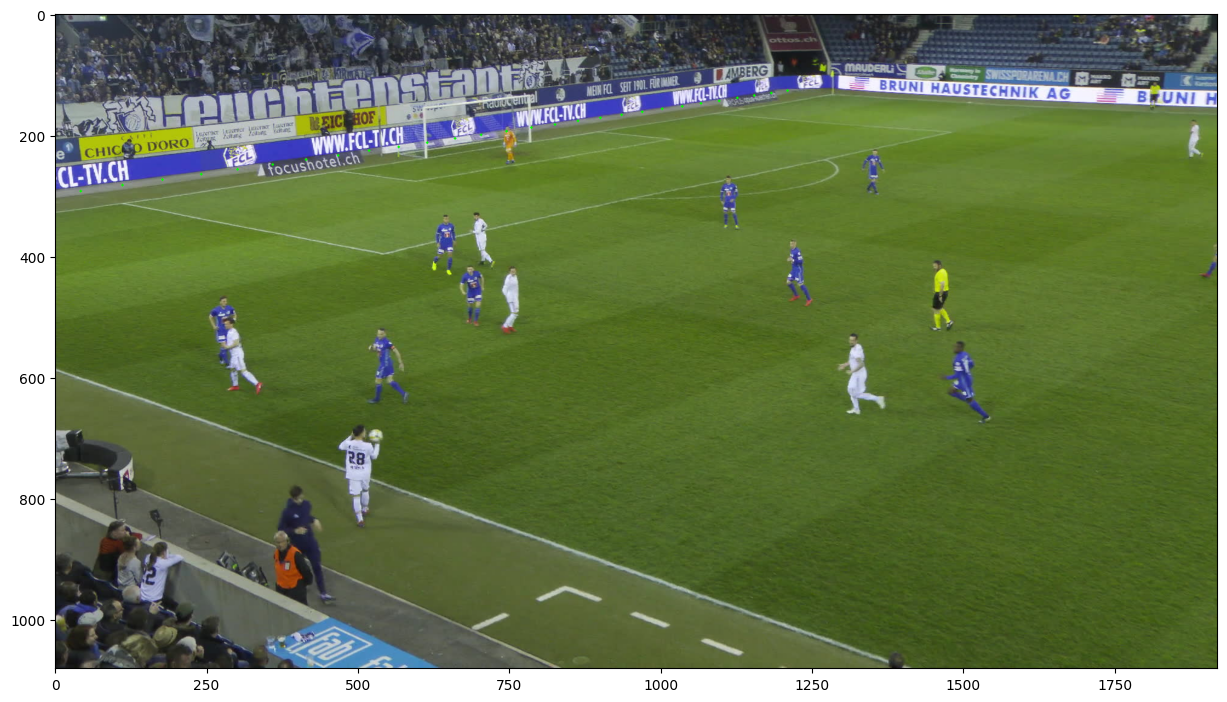

In [35]:
img2 = deepcopy(img)
for pt in points:
	pt = cam.project_point(pt, distort=True)[:2]
	cv2.circle(img2, tuple(pt.astype(np.int32)), 2, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

[[-528.45526   377.87064 ]
 [-528.45526   289.6218  ]
 [1208.6796     80.964905]
 [1208.6796    127.79301 ]]


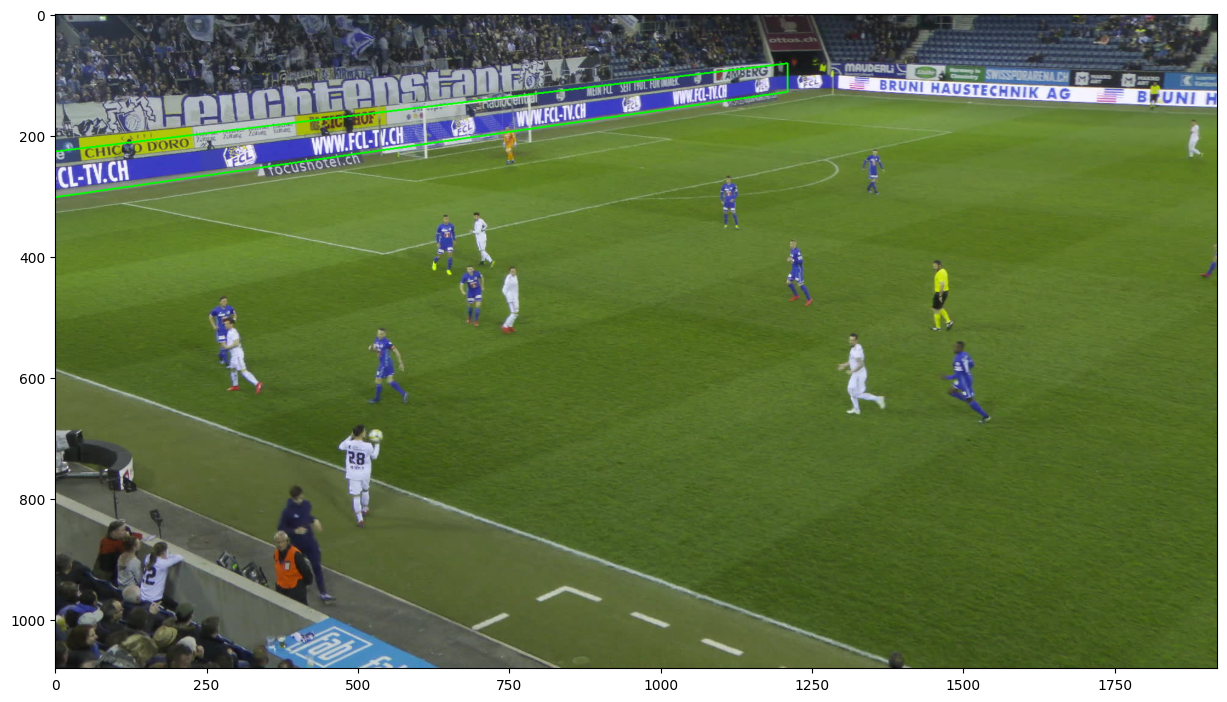

In [36]:
billboardHeight = 2
worldSrcPoints = np.float64([[-105/2 - billboardDepth, 34, 0], [-105/2 - billboardDepth, 34, -billboardHeight], [-105/2 - billboardDepth, -34, -billboardHeight], [-105/2 - billboardDepth, -34, 0]])
# worldSrcPoints = np.float64([[-105/2 - depth, 20, 0], [-105/2 - depth, 20, -billboardHeight], [-105/2 - depth, -34, -billboardHeight], [-105/2 - depth, -34, 0]])
srcPoints = np.float32([cam.project_point(pt, distort=False)[:2] for pt in worldSrcPoints])
srcPoints[1][0] = srcPoints[0][0]
srcPoints[2][0] = srcPoints[3][0]
print(srcPoints)
tmp = deepcopy(img)
cv2.polylines(tmp, [np.rint(srcPoints).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# !!! It is not done yet but it seems that a warpedImgHeight of odd size is better for cv.remap() function (to test with a grid) !!! Also 'warpedImgHeight' should be at least as great as the billboard new content height, or else there will be some loss when a down scaling is done later. But right now it is not very visible and it is expensive to not down scale

In [37]:
# To prevent loss of resolution when warping back the new content of the billboard, the warped image shoudl have a height greater than the height of the billow green window
warpedImgHeight = np.ceil(max(abs(srcPoints[0][1] - srcPoints[1][1]), abs(srcPoints[2][1] - srcPoints[3][1]))).astype(np.int32)
if warpedImgHeight % 2 == 0:
	warpedImgHeight += 1
print(warpedImgHeight)
warpedImgSize = (int(round(warpedImgHeight * 68 / billboardHeight)), warpedImgHeight)
warpedImgSize

89


(3026, 89)

In [38]:
dstPoints = np.float32([[0, warpedImgSize[1]], [0, 0], [warpedImgSize[0], 0], [warpedImgSize[0], warpedImgSize[1]]])
dstPoints

array([[   0.,   89.],
       [   0.,    0.],
       [3026.,    0.],
       [3026.,   89.]], dtype=float32)

In [39]:
M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
M

array([[ 1.07830931e+00,  8.95689472e-16,  5.69838231e+02],
       [ 1.41315760e-01,  1.17649854e+00, -2.66060564e+02],
       [-3.15199618e-04,  2.71671769e-19,  1.00000000e+00]])

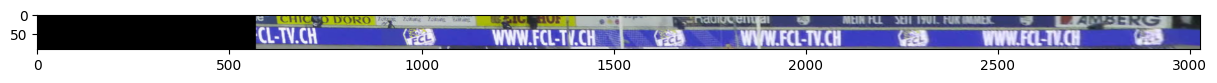

In [40]:
warpedImg = cv2.warpPerspective(img, M, warpedImgSize)
# the plot x axis should range from 0 to warpedImgSize[0] with a step of 100
plt.imshow(cv2.cvtColor(warpedImg, cv2.COLOR_BGR2RGB))

cv2.perspectiveTransform could be used to warp the points of "mask" and apply the linear regression on it, but it is more difficult to use and cv2.warpPerspective works just fine AND is way faster

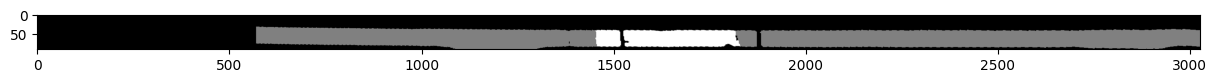

In [41]:
warpedMask = cv2.warpPerspective(mask, M, warpedImgSize)
plt.imshow(warpedMask, cmap='gray')
plt.savefig('warpedMask.png', dpi=600)

In [42]:
binWarpedMask = warpedMask > 0
y, x = np.where(binWarpedMask)
print(min(y), max(y), min(x), max(x))

32 88 570 3025


In [43]:
poly = PolynomialFeatures(degree=2, include_bias=True)
X = poly.fit_transform(x.reshape(-1, 1))
reg = LinearRegression().fit(X, y)
reg.predict(X).shape

(106659,)

In [44]:
Y = reg.predict(X)
width = np.mean(abs(y - Y)) * 4
width

44.160928263516695

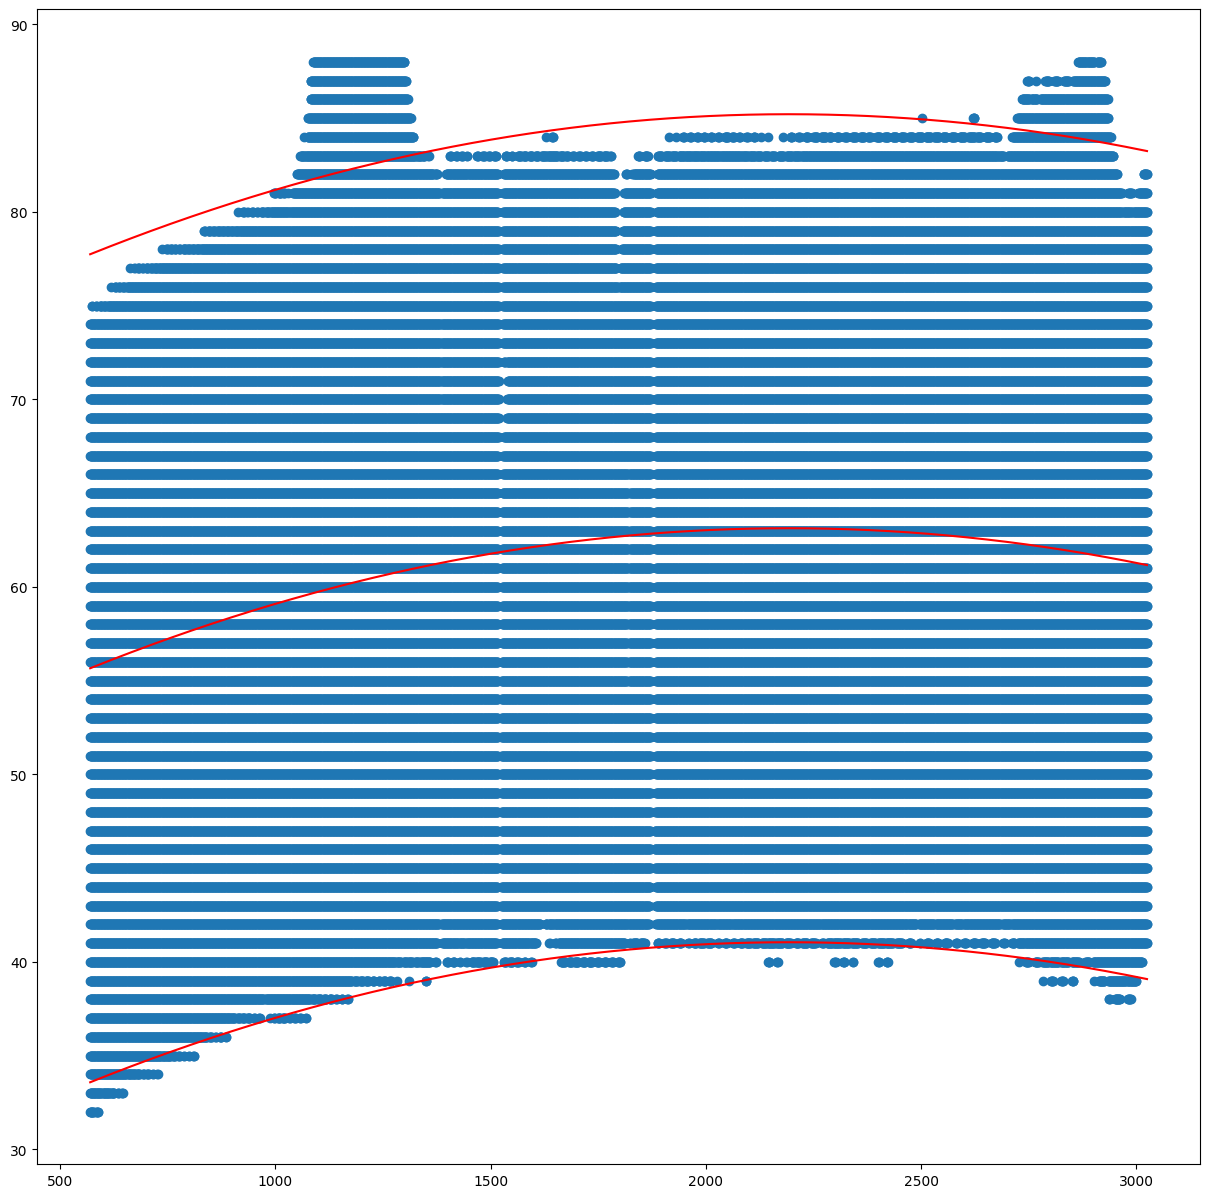

In [45]:
# plot x, y and the regression line
plt.scatter(x, y)
x_sorted = np.sort(x)
X_sorted = poly.fit_transform(x_sorted.reshape(-1, 1))
plt.plot(x_sorted, reg.predict(X_sorted), color='red')
plt.plot(x_sorted, reg.predict(X_sorted) + width/2, color='red')
plt.plot(x_sorted, reg.predict(X_sorted) - width/2, color='red')
plt.show()

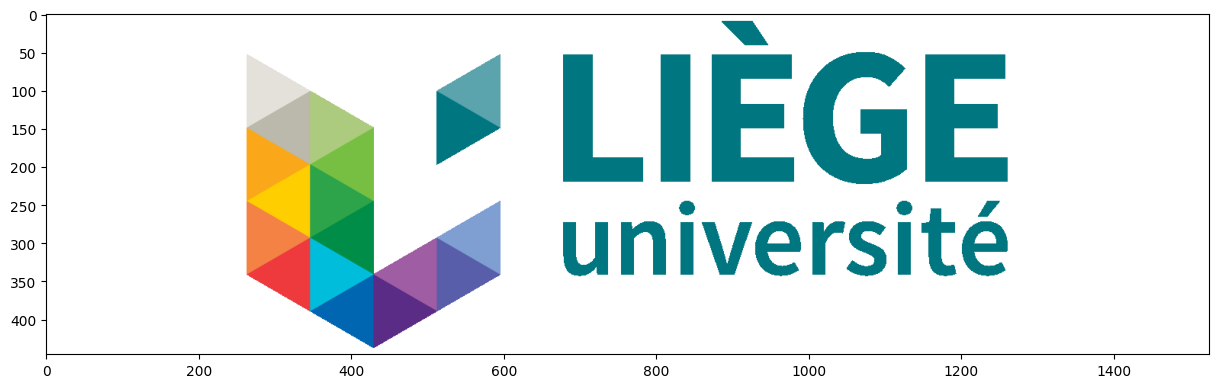

In [46]:
# pad in white of 50 pixels on each side
logo = cv2.imread('University_of_Liège_logo.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))

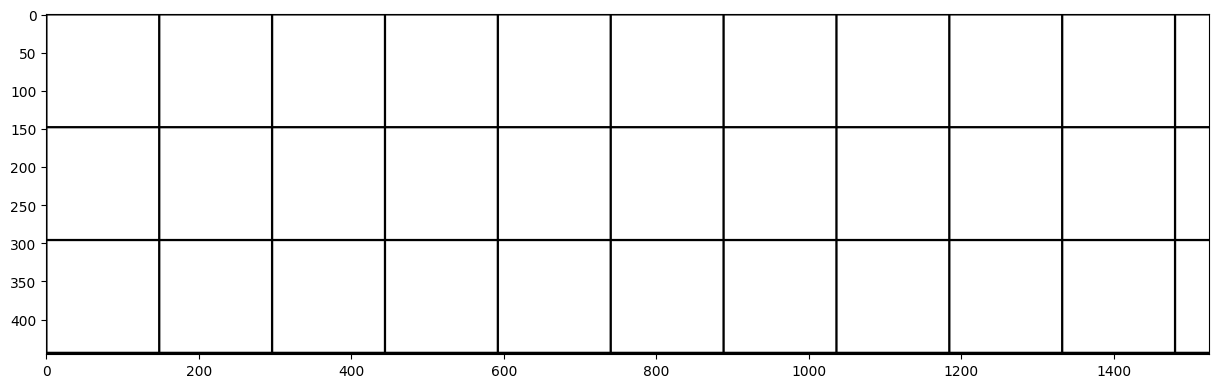

In [47]:
gridWidth = logo.shape[1]
gridHeight = logo.shape[0]
squareSize = gridHeight // 3
grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
grid.fill(255)
for i in range(0, gridWidth, squareSize):
	cv2.line(grid, (i, 0), (i, gridHeight), (0, 0, 0), 2)
for i in range(0, gridHeight, squareSize):
	cv2.line(grid, (0, i), (gridWidth, i), (0, 0, 0), 2)
plt.imshow(grid)

In [48]:
logo = grid

In [49]:
logoWidthInPixels = int(round(logo.shape[1] / logo.shape[0] * width))  # width of the logo in pixels
logoWidthInPixels

151

In [50]:
x = np.arange(0, warpedImg.shape[1], logoWidthInPixels, dtype=np.int32)
print(x)
xPoly = poly.fit_transform(x.reshape(-1, 1))
print(width)
y = [(x_ - width/2, x_ + width/2) for x_ in reg.predict(xPoly)]
y = np.rint(np.array(y)).astype(np.int32)
print(y)

[   0  151  302  453  604  755  906 1057 1208 1359 1510 1661 1812 1963
 2114 2265 2416 2567 2718 2869 3020]
44.160928263516695
[[27 72]
 [29 73]
 [31 75]
 [32 77]
 [34 78]
 [35 79]
 [36 81]
 [37 82]
 [38 82]
 [39 83]
 [40 84]
 [40 84]
 [41 85]
 [41 85]
 [41 85]
 [41 85]
 [41 85]
 [41 85]
 [40 84]
 [40 84]
 [39 83]]


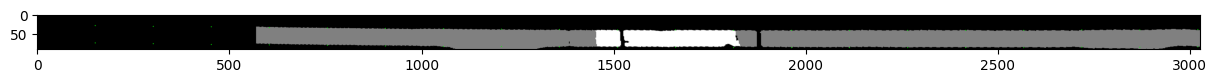

In [51]:
tmp = deepcopy(warpedMask)
tmp = cv2.normalize(tmp, None, 0, 255, cv2.NORM_MINMAX)
tmp = np.uint8(tmp)
tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)
# draw circles at the x and y coordinates
for i in range(len(x)):
    cv2.circle(tmp, (x[i], y[i][0]), 1, (0, 255, 0), -1)
    cv2.circle(tmp, (x[i], y[i][1]), 1, (0, 255, 0), -1)
plt.imshow(tmp)
plt.savefig('tmp.png', dpi=600)

In [52]:
MInverse = cv2.getPerspectiveTransform(dstPoints, srcPoints)  # could also use np.linalg.inv(M) but cv2.getPerspectiveTransform is 3 times faster

In [53]:
pt = np.float32([[3026, 89], [3026, 0]]).reshape(-1, 1, 2)
print(pt)
pt = cv2.perspectiveTransform(pt, MInverse).reshape(-1, 2)
print(pt)

[[[3026.   89.]]

 [[3026.    0.]]]
[[1208.6796    127.79301 ]
 [1208.6796     80.964905]]


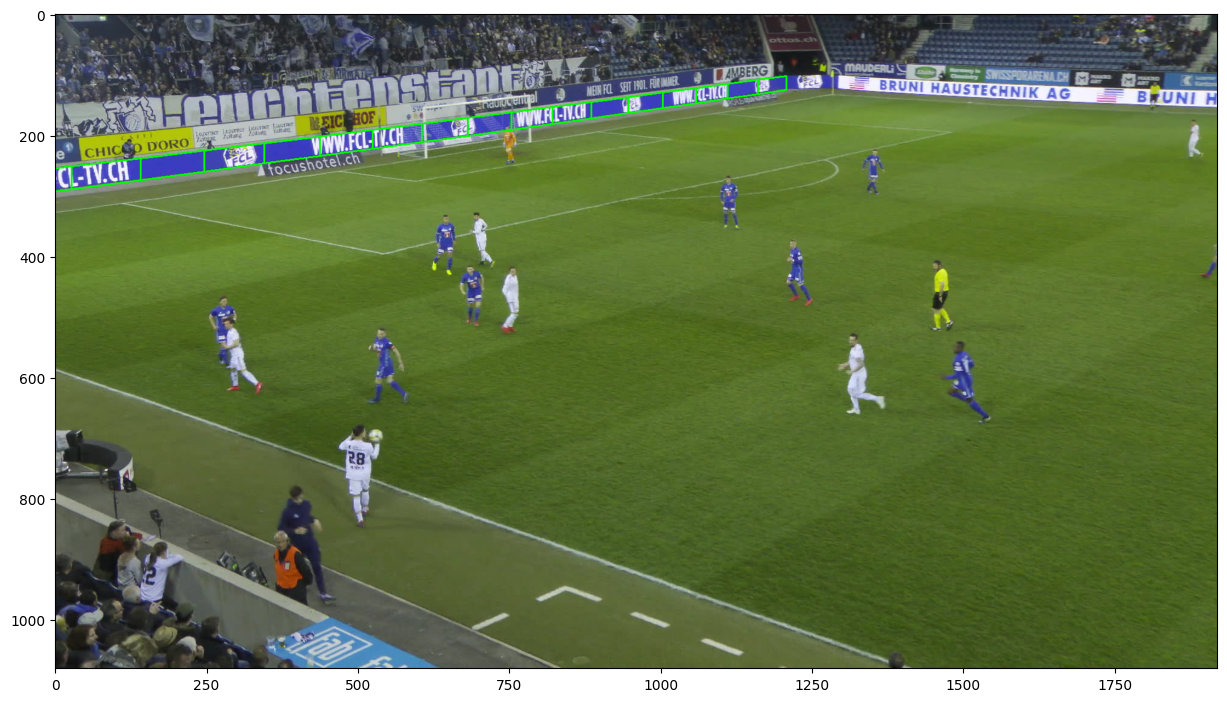

In [54]:
x = np.arange(0, warpedImg.shape[1], logoWidthInPixels, dtype=np.int32)
xPoly = poly.fit_transform(x.reshape(-1, 1))
yc = reg.predict(xPoly)
yt = yc - width/2
yb = yc + width/2
topLinePts = np.float32([[x_, y_] for x_, y_ in zip(x, yt)]).reshape(-1, 1, 2)
bottomLinePts = np.float32([[x_, y_] for x_, y_ in zip(x, yb)]).reshape(-1, 1, 2)
topLinePts = cv2.perspectiveTransform(topLinePts, MInverse).reshape(-1, 2)
bottomLinePts = cv2.perspectiveTransform(bottomLinePts, MInverse).reshape(-1, 2)
tmp = deepcopy(img)
# draw the top and bottom lines
# for i in range(1, len(topLinePts)):
#     cv2.line(tmp, tuple(topLinePts[i-1].astype(np.int32)), tuple(topLinePts[i].astype(np.int32)), (0, 255, 0), 2)
#     cv2.line(tmp, tuple(bottomLinePts[i-1].astype(np.int32)), tuple(bottomLinePts[i].astype(np.int32)), (0, 255, 0), 2)
# draw boxes
for i in range(1, len(topLinePts)):
    cv2.polylines(tmp, [np.rint(np.float32([topLinePts[i-1], topLinePts[i], bottomLinePts[i], bottomLinePts[i-1]])).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

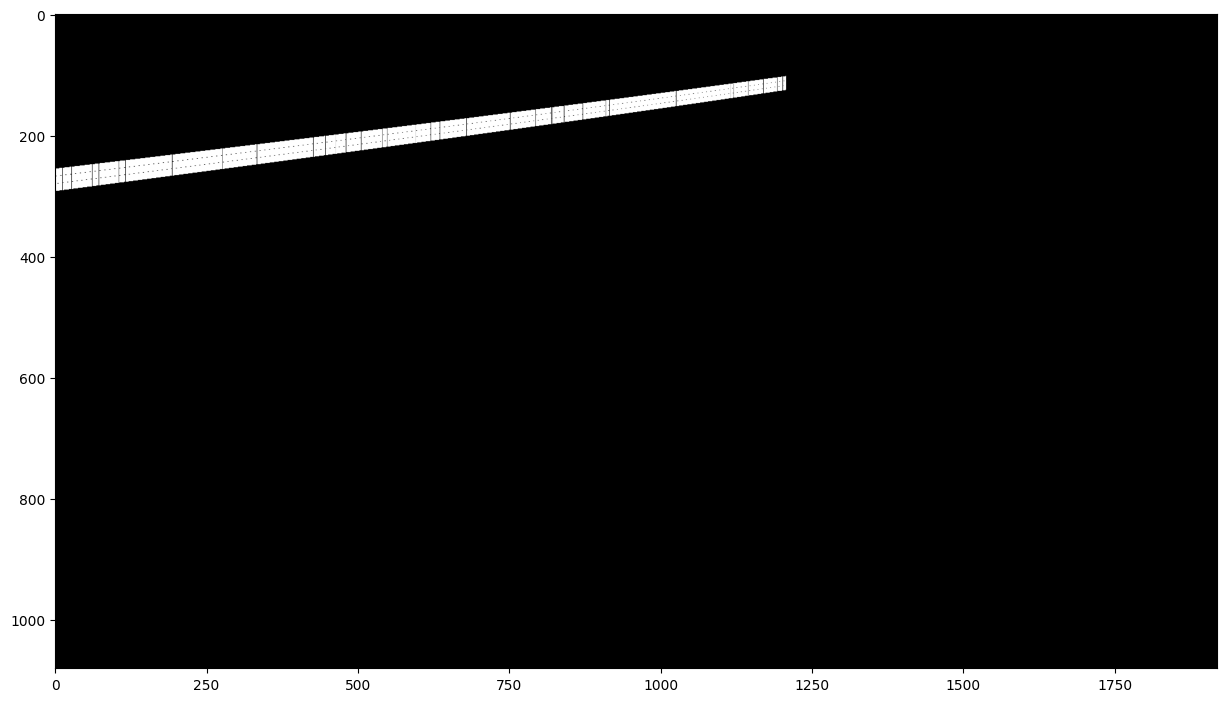

In [58]:
tmp = np.zeros_like(img)
srcPts2 = np.float32([[0, 0], [logo.shape[1], 0], [logo.shape[1], logo.shape[0]], [0, logo.shape[0]]])
for i in range(1, len(topLinePts)):
    billPts = np.float32([topLinePts[i-1], topLinePts[i], bottomLinePts[i], bottomLinePts[i-1]])
    M2 = cv2.getPerspectiveTransform(srcPts2, billPts)
    warpedLogo = cv2.warpPerspective(logo, M2, (img.shape[1], img.shape[0]))
    tmp = cv2.bitwise_or(tmp, warpedLogo)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

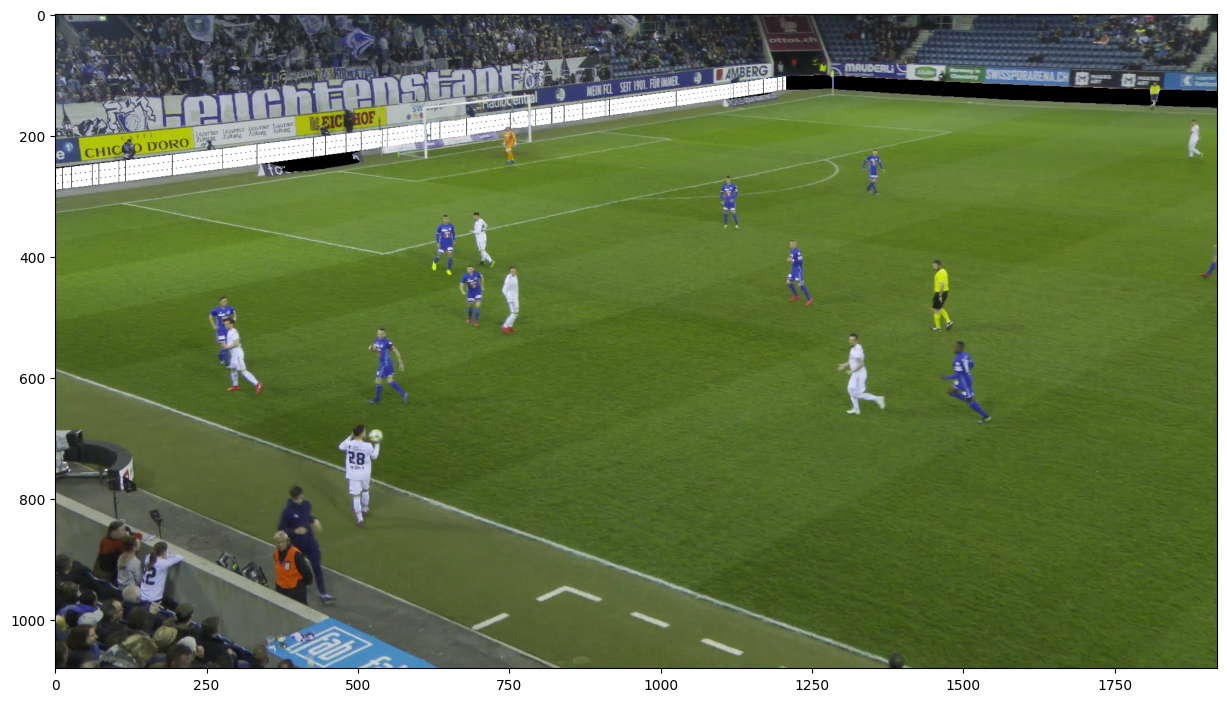

In [59]:
binMask = mask > 0
img[binMask] = tmp[binMask]
# save image
cv2.imwrite('final.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))